## 최적의 토픽개수 구하기

In [71]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt
import nltk

In [72]:
df = pd.read_csv('/Users/hayeon/Downloads/reviews.csv') # Restaurant Reviews in Dhaka, Bangladesh
df.head()

,Review Text,Review,Recommends
0,"Friendly staff, good food and homely environme...",NaN,True
1,Well...The Food was Good___Intrerior design is...,NaN,True
2,The man who is foodie like me for him arabian ...,5.0,NaN
3,ordered pizza and they were unable to serve th...,NaN,False
4,This place is too much comfortable & food is d...,4.0,NaN


In [73]:
# 특수문자 제거
df['clean_doc'] = df['Review Text'].str.replace("[^a-zA-Z]", ' ')

# 길이가 3 이하의 단어는 제거 (길이가 짧은 단어 제거)
df['clean_doc'] = df['clean_doc'].apply(lambda x : ' '.join([w for w in x.split() if len(w) >3]))

# 전체 단어에 대한 소문자 변환
df['clean_doc'] = df['clean_doc'].apply(lambda x: x.lower())

In [74]:
df

,Review Text,Review,Recommends,clean_doc
0,"Friendly staff, good food and homely environme...",NaN,True,friendly staff good food homely environment
1,Well...The Food was Good___Intrerior design is...,NaN,True,well food good intrerior design nice environme...
2,The man who is foodie like me for him arabian ...,5.0,NaN,foodie like arabian master nice place environm...
3,ordered pizza and they were unable to serve th...,NaN,False,ordered pizza they were unable serve then orde...
4,This place is too much comfortable & food is d...,4.0,NaN,this place much comfortable food delicious eve...
...,...,...,...,...
16592,Firstly their ac didn't work just useless and ...,1.0,NaN,firstly their didn work just useless secondly ...
16593,good food with good environment,NaN,True,good food with good environment
16594,Best Thai soup of the town,5.0,NaN,best thai soup town
16595,really nice place with so many good ppls.,NaN,True,really nice place with many good ppls


In [75]:
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = stopwords.words('english')

tokenized_doc = df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hayeon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [76]:
print(tokenized_doc[1])

['well', 'food', 'good', 'intrerior', 'design', 'nice', 'environment', 'quite', 'fakafaka', 'background', 'music', 'good', 'gives']


In [77]:
pd.DataFrame(tokenized_doc)

,clean_doc
0,"[friendly, staff, good, food, homely, environm..."
1,"[well, food, good, intrerior, design, nice, en..."
2,"[foodie, like, arabian, master, nice, place, e..."
3,"[ordered, pizza, unable, serve, ordered, menu,..."
4,"[place, much, comfortable, food, delicious, ev..."
...,...
16592,"[firstly, work, useless, secondly, behavior, w..."
16593,"[good, food, good, environment]"
16594,"[best, thai, soup, town]"
16595,"[really, nice, place, many, good, ppls]"


In [78]:
okt = Okt()
tokenized_data = []

for i in df['clean_doc']:
    temp_X = okt.morphs(i, stem = True)
    tokenized_data.append(temp_X)
    
pd.DataFrame(tokenized_data).to_csv('review_tokenized.csv')

In [79]:
pd.DataFrame(tokenized_data)

,0,1,2,3,4,5,6,7,8,9,...,275,276,277,278,279,280,281,282,283,284
0,friendly,staff,good,food,homely,environment,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,well,food,good,intrerior,design,nice,environment,quite,fakafaka,background,...,None,None,None,None,None,None,None,None,None,None
2,foodie,like,arabian,master,nice,place,environment,food,quality,good,...,None,None,None,None,None,None,None,None,None,None
3,ordered,pizza,they,were,unable,serve,then,ordered,menu,then,...,None,None,None,None,None,None,None,None,None,None
4,this,place,much,comfortable,food,delicious,every,item,testy,pizza,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16592,firstly,their,didn,work,just,useless,secondly,behavior,their,waiter,...,None,None,None,None,None,None,None,None,None,None
16593,good,food,with,good,environment,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
16594,best,thai,soup,town,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
16595,really,nice,place,with,many,good,ppls,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
!pip3 install pyLDAvis

In [80]:
import warnings 
warnings.filterwarnings('ignore')

In [81]:
from tqdm import tqdm
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import CoherenceMetric
from gensim import corpora
from gensim.models.callbacks import PerplexityMetric
import logging
import pyLDAvis.gensim_models
from gensim.models.coherencemodel import CoherenceModel

100%|██████████| 16598/16598 [00:03<00:00, 4306.25it/s]
2022-05-22 19:05:18,297 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2022-05-22 19:05:18,674 : INFO : adding document #10000 to Dictionary(19897 unique tokens: ['', '0', '1', '10', '100']...)
2022-05-22 19:05:18,925 : INFO : built Dictionary(29673 unique tokens: ['', '0', '1', '10', '100']...) from 16598 documents (total 4747028 corpus positions)
2022-05-22 19:05:19,536 : INFO : discarding 27831 tokens: [('', 16597), ('0', 2), ('1', 2), ('10', 2), ('100', 2), ('101', 2), ('102', 2), ('103', 2), ('104', 2), ('105', 2)]...
2022-05-22 19:05:19,547 : INFO : keeping 1842 tokens which were in no less than 10 and no more than 829 (=5.0%) documents
2022-05-22 19:05:19,553 : INFO : resulting dictionary: Dictionary(1842 unique tokens: ['friendly', 'homely', 'staff', 'background', 'design']...)
2022-05-22 19:05:20,068 : INFO : using symmetric alpha at 0.5
2022-05-22 19:05:20,069 : INFO : using symmetric eta at 0.5
2022-05-2

Number of unique tokens: 1842
Number of documents: 16598


2022-05-22 19:05:20,770 : INFO : merging changes from 2000 documents into a model of 16598 documents
2022-05-22 19:05:20,771 : INFO : topic #0 (0.500): 0.010*"excellent" + 0.009*"burger" + 0.009*"foods" + 0.009*"platter" + 0.009*"hakka" + 0.008*"visit" + 0.008*"your" + 0.008*"quantity" + 0.008*"rice" + 0.008*"dhaka"
2022-05-22 19:05:20,771 : INFO : topic #1 (0.500): 0.010*"much" + 0.008*"should" + 0.008*"burger" + 0.007*"worst" + 0.007*"from" + 0.007*"more" + 0.006*"which" + 0.006*"after" + 0.006*"menu" + 0.006*"ever"
2022-05-22 19:05:20,772 : INFO : topic diff=1.628355, rho=1.000000
2022-05-22 19:05:20,772 : INFO : PROGRESS: pass 0, at document #4000/16598
2022-05-22 19:05:21,320 : INFO : merging changes from 2000 documents into a model of 16598 documents
2022-05-22 19:05:21,321 : INFO : topic #0 (0.500): 0.011*"foods" + 0.010*"excellent" + 0.009*"steak" + 0.009*"your" + 0.008*"visit" + 0.008*"amazing" + 0.007*"dhaka" + 0.007*"burger" + 0.007*"rice" + 0.006*"keep"
2022-05-22 19:05:21,

2022-05-22 19:05:26,022 : INFO : 19 batches submitted to accumulate stats from 1216 documents (215232 virtual)
2022-05-22 19:05:26,037 : INFO : 20 batches submitted to accumulate stats from 1280 documents (226560 virtual)
2022-05-22 19:05:26,041 : INFO : 21 batches submitted to accumulate stats from 1344 documents (237888 virtual)
2022-05-22 19:05:26,050 : INFO : 22 batches submitted to accumulate stats from 1408 documents (249216 virtual)
2022-05-22 19:05:26,061 : INFO : 23 batches submitted to accumulate stats from 1472 documents (260544 virtual)
2022-05-22 19:05:26,070 : INFO : 24 batches submitted to accumulate stats from 1536 documents (271872 virtual)
2022-05-22 19:05:26,075 : INFO : 25 batches submitted to accumulate stats from 1600 documents (283200 virtual)
2022-05-22 19:05:26,085 : INFO : 26 batches submitted to accumulate stats from 1664 documents (294528 virtual)
2022-05-22 19:05:26,109 : INFO : 27 batches submitted to accumulate stats from 1728 documents (305856 virtual)
2

2022-05-22 19:05:26,867 : INFO : 93 batches submitted to accumulate stats from 5952 documents (1053504 virtual)
2022-05-22 19:05:26,876 : INFO : 94 batches submitted to accumulate stats from 6016 documents (1064832 virtual)
2022-05-22 19:05:26,884 : INFO : 95 batches submitted to accumulate stats from 6080 documents (1076160 virtual)
2022-05-22 19:05:26,892 : INFO : 96 batches submitted to accumulate stats from 6144 documents (1087488 virtual)
2022-05-22 19:05:26,900 : INFO : 97 batches submitted to accumulate stats from 6208 documents (1098816 virtual)
2022-05-22 19:05:26,911 : INFO : 98 batches submitted to accumulate stats from 6272 documents (1110144 virtual)
2022-05-22 19:05:26,924 : INFO : 99 batches submitted to accumulate stats from 6336 documents (1121472 virtual)
2022-05-22 19:05:26,933 : INFO : 100 batches submitted to accumulate stats from 6400 documents (1132800 virtual)
2022-05-22 19:05:26,947 : INFO : 101 batches submitted to accumulate stats from 6464 documents (1144128

2022-05-22 19:05:27,961 : INFO : PROGRESS: pass 0, at document #4000/16598
2022-05-22 19:05:28,292 : INFO : merging changes from 2000 documents into a model of 16598 documents
2022-05-22 19:05:28,293 : INFO : topic #0 (0.125): 0.037*"coffee" + 0.019*"steaks" + 0.010*"ordered" + 0.009*"serve" + 0.009*"ever" + 0.009*"steak" + 0.008*"yummy" + 0.008*"menu" + 0.008*"much" + 0.008*"salad"
2022-05-22 19:05:28,294 : INFO : topic #7 (0.125): 0.020*"excellent" + 0.019*"dhaka" + 0.017*"worst" + 0.013*"from" + 0.012*"town" + 0.011*"most" + 0.008*"keep" + 0.007*"rare" + 0.007*"always" + 0.007*"steak"
2022-05-22 19:05:28,294 : INFO : topic #4 (0.125): 0.017*"coffee" + 0.013*"friends" + 0.011*"quantity" + 0.011*"must" + 0.009*"reasonable" + 0.009*"hangout" + 0.009*"excellent" + 0.009*"platter" + 0.009*"medium" + 0.009*"here"
2022-05-22 19:05:28,295 : INFO : topic #5 (0.125): 0.013*"visit" + 0.011*"more" + 0.011*"foods" + 0.011*"poor" + 0.011*"steak" + 0.010*"than" + 0.010*"about" + 0.010*"keep" + 0.0

2022-05-22 19:05:30,060 : INFO : topic #2 (0.125): 0.023*"valo" + 0.022*"should" + 0.020*"chilo" + 0.019*"buffet" + 0.018*"khabar" + 0.015*"overall" + 0.014*"items" + 0.012*"behaviour" + 0.012*"improve" + 0.011*"baje"
2022-05-22 19:05:30,060 : INFO : topic #4 (0.125): 0.020*"quantity" + 0.016*"friends" + 0.015*"enough" + 0.014*"family" + 0.012*"beautiful" + 0.012*"hangout" + 0.011*"ambience" + 0.011*"everything" + 0.010*"less" + 0.010*"fish"
2022-05-22 19:05:30,060 : INFO : topic #5 (0.125): 0.024*"poor" + 0.016*"more" + 0.014*"than" + 0.014*"delivery" + 0.011*"customer" + 0.011*"your" + 0.010*"visit" + 0.010*"customers" + 0.009*"items" + 0.008*"need"
2022-05-22 19:05:30,061 : INFO : topic #6 (0.125): 0.021*"keep" + 0.021*"reasonable" + 0.017*"much" + 0.017*"yummy" + 0.016*"decoration" + 0.013*"excellent" + 0.013*"fresh" + 0.013*"luck" + 0.011*"news" + 0.011*"burger"
2022-05-22 19:05:30,061 : INFO : topic diff=0.272154, rho=0.353553
2022-05-22 19:05:30,170 : INFO : -7.283 per-word boun

2022-05-22 19:05:32,692 : INFO : 53 batches submitted to accumulate stats from 3392 documents (600384 virtual)
2022-05-22 19:05:32,702 : INFO : 54 batches submitted to accumulate stats from 3456 documents (611712 virtual)
2022-05-22 19:05:32,715 : INFO : 55 batches submitted to accumulate stats from 3520 documents (623040 virtual)
2022-05-22 19:05:32,723 : INFO : 56 batches submitted to accumulate stats from 3584 documents (634368 virtual)
2022-05-22 19:05:32,734 : INFO : 57 batches submitted to accumulate stats from 3648 documents (645696 virtual)
2022-05-22 19:05:32,741 : INFO : 58 batches submitted to accumulate stats from 3712 documents (657024 virtual)
2022-05-22 19:05:32,750 : INFO : 59 batches submitted to accumulate stats from 3776 documents (668352 virtual)
2022-05-22 19:05:32,764 : INFO : 60 batches submitted to accumulate stats from 3840 documents (679680 virtual)
2022-05-22 19:05:32,774 : INFO : 61 batches submitted to accumulate stats from 3904 documents (691008 virtual)
2

2022-05-22 19:05:33,544 : INFO : 127 batches submitted to accumulate stats from 8128 documents (1438656 virtual)
2022-05-22 19:05:33,556 : INFO : 128 batches submitted to accumulate stats from 8192 documents (1449984 virtual)
2022-05-22 19:05:33,566 : INFO : 129 batches submitted to accumulate stats from 8256 documents (1461312 virtual)
2022-05-22 19:05:33,578 : INFO : 130 batches submitted to accumulate stats from 8320 documents (1472640 virtual)
2022-05-22 19:05:33,593 : INFO : 131 batches submitted to accumulate stats from 8384 documents (1483968 virtual)
2022-05-22 19:05:33,604 : INFO : 132 batches submitted to accumulate stats from 8448 documents (1495296 virtual)
2022-05-22 19:05:33,614 : INFO : 133 batches submitted to accumulate stats from 8512 documents (1506624 virtual)
2022-05-22 19:05:33,623 : INFO : 134 batches submitted to accumulate stats from 8576 documents (1517952 virtual)
2022-05-22 19:05:33,633 : INFO : 135 batches submitted to accumulate stats from 8640 documents (

2022-05-22 19:05:34,688 : INFO : using symmetric eta at 0.07142857142857142
2022-05-22 19:05:34,688 : INFO : using serial LDA version on this node
2022-05-22 19:05:34,690 : INFO : running online (single-pass) LDA training, 14 topics, 1 passes over the supplied corpus of 16598 documents, updating model once every 2000 documents, evaluating perplexity every 16598 documents, iterating 50x with a convergence threshold of 0.001000
2022-05-22 19:05:34,690 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2022-05-22 19:05:34,692 : INFO : PROGRESS: pass 0, at document #2000/16598
2022-05-22 19:05:35,061 : INFO : merging changes from 2000 documents into a model of 16598 documents
2022-05-22 19:05:35,062 : INFO : topic #13 (0.071): 0.014*"ordered" + 0.014*"spicy" + 0.011*"beef" + 0.010*"amazing" + 0.010*"from" + 0.010*"platter" + 0.010*"quantity" + 0.009*"excellent" + 0.008*"here" + 0.008*"yummy"
2022-05-22 19:05:

2022-05-22 19:05:36,467 : INFO : topic #7 (0.071): 0.043*"valo" + 0.039*"chilo" + 0.034*"khabar" + 0.032*"offer" + 0.025*"city" + 0.024*"khub" + 0.021*"baje" + 0.019*"view" + 0.016*"onek" + 0.016*"pasta"
2022-05-22 19:05:36,467 : INFO : topic diff=0.273529, rho=0.408248
2022-05-22 19:05:36,468 : INFO : PROGRESS: pass 0, at document #14000/16598
2022-05-22 19:05:36,711 : INFO : merging changes from 2000 documents into a model of 16598 documents
2022-05-22 19:05:36,713 : INFO : topic #6 (0.071): 0.039*"behavior" + 0.035*"foods" + 0.016*"customer" + 0.014*"them" + 0.013*"waiter" + 0.013*"testy" + 0.013*"much" + 0.012*"star" + 0.011*"behaviour" + 0.010*"change"
2022-05-22 19:05:36,713 : INFO : topic #13 (0.071): 0.032*"pizzas" + 0.027*"ordered" + 0.021*"delivery" + 0.017*"services" + 0.016*"home" + 0.015*"khilgaon" + 0.013*"quite" + 0.013*"favourite" + 0.012*"from" + 0.012*"here"
2022-05-22 19:05:36,713 : INFO : topic #7 (0.071): 0.048*"chilo" + 0.048*"valo" + 0.037*"offer" + 0.031*"pasta"

2022-05-22 19:05:39,455 : INFO : 34 batches submitted to accumulate stats from 2176 documents (385152 virtual)
2022-05-22 19:05:39,474 : INFO : 35 batches submitted to accumulate stats from 2240 documents (396480 virtual)
2022-05-22 19:05:39,480 : INFO : 36 batches submitted to accumulate stats from 2304 documents (407808 virtual)
2022-05-22 19:05:39,490 : INFO : 37 batches submitted to accumulate stats from 2368 documents (419136 virtual)
2022-05-22 19:05:39,524 : INFO : 38 batches submitted to accumulate stats from 2432 documents (430464 virtual)
2022-05-22 19:05:39,533 : INFO : 39 batches submitted to accumulate stats from 2496 documents (441792 virtual)
2022-05-22 19:05:39,547 : INFO : 40 batches submitted to accumulate stats from 2560 documents (453120 virtual)
2022-05-22 19:05:39,557 : INFO : 41 batches submitted to accumulate stats from 2624 documents (464448 virtual)
2022-05-22 19:05:39,566 : INFO : 42 batches submitted to accumulate stats from 2688 documents (475776 virtual)
2

2022-05-22 19:05:40,437 : INFO : 108 batches submitted to accumulate stats from 6912 documents (1223424 virtual)
2022-05-22 19:05:40,442 : INFO : 109 batches submitted to accumulate stats from 6976 documents (1234752 virtual)
2022-05-22 19:05:40,450 : INFO : 110 batches submitted to accumulate stats from 7040 documents (1246080 virtual)
2022-05-22 19:05:40,457 : INFO : 111 batches submitted to accumulate stats from 7104 documents (1257408 virtual)
2022-05-22 19:05:40,472 : INFO : 112 batches submitted to accumulate stats from 7168 documents (1268736 virtual)
2022-05-22 19:05:40,483 : INFO : 113 batches submitted to accumulate stats from 7232 documents (1280064 virtual)
2022-05-22 19:05:40,491 : INFO : 114 batches submitted to accumulate stats from 7296 documents (1291392 virtual)
2022-05-22 19:05:40,497 : INFO : 115 batches submitted to accumulate stats from 7360 documents (1302720 virtual)
2022-05-22 19:05:40,506 : INFO : 116 batches submitted to accumulate stats from 7424 documents (

2022-05-22 19:05:41,325 : INFO : 181 batches submitted to accumulate stats from 11584 documents (2050368 virtual)
2022-05-22 19:05:41,338 : INFO : 182 batches submitted to accumulate stats from 11648 documents (2061696 virtual)
2022-05-22 19:05:41,343 : INFO : 183 batches submitted to accumulate stats from 11712 documents (2073024 virtual)
2022-05-22 19:05:41,347 : INFO : 184 batches submitted to accumulate stats from 11776 documents (2084352 virtual)
2022-05-22 19:05:41,357 : INFO : 185 batches submitted to accumulate stats from 11840 documents (2095680 virtual)
2022-05-22 19:05:41,385 : INFO : 186 batches submitted to accumulate stats from 11904 documents (2107008 virtual)
2022-05-22 19:05:41,405 : INFO : 187 batches submitted to accumulate stats from 11968 documents (2118336 virtual)
2022-05-22 19:05:41,409 : INFO : 188 batches submitted to accumulate stats from 12032 documents (2129664 virtual)
2022-05-22 19:05:41,419 : INFO : 189 batches submitted to accumulate stats from 12096 do

2022-05-22 19:05:43,226 : INFO : topic diff=0.344539, rho=0.577350
2022-05-22 19:05:43,228 : INFO : PROGRESS: pass 0, at document #8000/16598
2022-05-22 19:05:43,493 : INFO : merging changes from 2000 documents into a model of 16598 documents
2022-05-22 19:05:43,495 : INFO : topic #19 (0.050): 0.042*"keep" + 0.039*"naga" + 0.019*"work" + 0.017*"favorite" + 0.017*"ever" + 0.017*"meat" + 0.016*"mind" + 0.014*"burger" + 0.014*"think" + 0.014*"test"
2022-05-22 19:05:43,495 : INFO : topic #7 (0.050): 0.024*"chocolate" + 0.022*"when" + 0.020*"coffee" + 0.019*"charge" + 0.018*"burger" + 0.017*"order" + 0.014*"after" + 0.012*"menu" + 0.012*"then" + 0.012*"quite"
2022-05-22 19:05:43,496 : INFO : topic #11 (0.050): 0.025*"reasonable" + 0.025*"about" + 0.023*"people" + 0.021*"more" + 0.020*"thai" + 0.020*"live" + 0.018*"authentic" + 0.017*"ever" + 0.015*"quite" + 0.014*"serve"
2022-05-22 19:05:43,496 : INFO : topic #0 (0.050): 0.026*"burgers" + 0.024*"excellent" + 0.023*"thai" + 0.022*"must" + 0.

2022-05-22 19:05:45,343 : INFO : 1 batches submitted to accumulate stats from 64 documents (11328 virtual)
2022-05-22 19:05:45,351 : INFO : 2 batches submitted to accumulate stats from 128 documents (22656 virtual)
2022-05-22 19:05:45,358 : INFO : 3 batches submitted to accumulate stats from 192 documents (33984 virtual)
2022-05-22 19:05:45,365 : INFO : 4 batches submitted to accumulate stats from 256 documents (45312 virtual)
2022-05-22 19:05:45,370 : INFO : 5 batches submitted to accumulate stats from 320 documents (56640 virtual)
2022-05-22 19:05:45,380 : INFO : 6 batches submitted to accumulate stats from 384 documents (67968 virtual)
2022-05-22 19:05:45,391 : INFO : 7 batches submitted to accumulate stats from 448 documents (79296 virtual)
2022-05-22 19:05:46,288 : INFO : 8 batches submitted to accumulate stats from 512 documents (90624 virtual)
2022-05-22 19:05:46,381 : INFO : 9 batches submitted to accumulate stats from 576 documents (101952 virtual)
2022-05-22 19:05:46,469 : IN

2022-05-22 19:05:47,864 : INFO : 76 batches submitted to accumulate stats from 4864 documents (860928 virtual)
2022-05-22 19:05:47,873 : INFO : 77 batches submitted to accumulate stats from 4928 documents (872256 virtual)
2022-05-22 19:05:47,880 : INFO : 78 batches submitted to accumulate stats from 4992 documents (883584 virtual)
2022-05-22 19:05:47,896 : INFO : 79 batches submitted to accumulate stats from 5056 documents (894912 virtual)
2022-05-22 19:05:47,925 : INFO : 80 batches submitted to accumulate stats from 5120 documents (906240 virtual)
2022-05-22 19:05:47,938 : INFO : 81 batches submitted to accumulate stats from 5184 documents (917568 virtual)
2022-05-22 19:05:47,952 : INFO : 82 batches submitted to accumulate stats from 5248 documents (928896 virtual)
2022-05-22 19:05:47,980 : INFO : 83 batches submitted to accumulate stats from 5312 documents (940224 virtual)
2022-05-22 19:05:47,998 : INFO : 84 batches submitted to accumulate stats from 5376 documents (951552 virtual)
2

2022-05-22 19:05:48,902 : INFO : 149 batches submitted to accumulate stats from 9536 documents (1687872 virtual)
2022-05-22 19:05:48,912 : INFO : 150 batches submitted to accumulate stats from 9600 documents (1699200 virtual)
2022-05-22 19:05:48,916 : INFO : 151 batches submitted to accumulate stats from 9664 documents (1710528 virtual)
2022-05-22 19:05:48,926 : INFO : 152 batches submitted to accumulate stats from 9728 documents (1721856 virtual)
2022-05-22 19:05:48,947 : INFO : 153 batches submitted to accumulate stats from 9792 documents (1733184 virtual)
2022-05-22 19:05:48,957 : INFO : 154 batches submitted to accumulate stats from 9856 documents (1744512 virtual)
2022-05-22 19:05:48,987 : INFO : 155 batches submitted to accumulate stats from 9920 documents (1755840 virtual)
2022-05-22 19:05:48,996 : INFO : 156 batches submitted to accumulate stats from 9984 documents (1767168 virtual)
2022-05-22 19:05:49,014 : INFO : 157 batches submitted to accumulate stats from 10048 documents 

2022-05-22 19:05:50,702 : INFO : running online (single-pass) LDA training, 26 topics, 1 passes over the supplied corpus of 16598 documents, updating model once every 2000 documents, evaluating perplexity every 16598 documents, iterating 50x with a convergence threshold of 0.001000
2022-05-22 19:05:50,702 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2022-05-22 19:05:50,703 : INFO : PROGRESS: pass 0, at document #2000/16598
2022-05-22 19:05:51,093 : INFO : merging changes from 2000 documents into a model of 16598 documents
2022-05-22 19:05:51,095 : INFO : topic #14 (0.038): 0.013*"rice" + 0.013*"worst" + 0.012*"fried" + 0.012*"amazing" + 0.011*"your" + 0.010*"foods" + 0.009*"chinese" + 0.008*"branch" + 0.008*"hakka" + 0.008*"better"
2022-05-22 19:05:51,096 : INFO : topic #25 (0.038): 0.013*"from" + 0.011*"foods" + 0.011*"should" + 0.011*"serve" + 0.011*"your" + 0.010*"behavior" + 0.010*"dhaka" + 0.01

2022-05-22 19:05:53,017 : INFO : topic diff=0.241962, rho=0.408248
2022-05-22 19:05:53,019 : INFO : PROGRESS: pass 0, at document #14000/16598
2022-05-22 19:05:53,295 : INFO : merging changes from 2000 documents into a model of 16598 documents
2022-05-22 19:05:53,296 : INFO : topic #13 (0.038): 0.052*"cheese" + 0.031*"more" + 0.027*"sauce" + 0.023*"most" + 0.021*"large" + 0.021*"beef" + 0.019*"dishes" + 0.017*"garlic" + 0.016*"which" + 0.015*"items"
2022-05-22 19:05:53,297 : INFO : topic #7 (0.038): 0.041*"over" + 0.026*"dessert" + 0.022*"salad" + 0.022*"iftar" + 0.020*"nothing" + 0.019*"totally" + 0.018*"item" + 0.018*"looking" + 0.017*"platter" + 0.017*"special"
2022-05-22 19:05:53,297 : INFO : topic #1 (0.038): 0.084*"town" + 0.068*"family" + 0.059*"friends" + 0.052*"hangout" + 0.040*"liked" + 0.029*"interior" + 0.027*"birthday" + 0.023*"friendly" + 0.022*"steak" + 0.016*"shop"
2022-05-22 19:05:53,298 : INFO : topic #19 (0.038): 0.063*"burger" + 0.027*"cheesy" + 0.026*"simply" + 0.0

2022-05-22 19:05:56,699 : INFO : 37 batches submitted to accumulate stats from 2368 documents (419136 virtual)
2022-05-22 19:05:56,727 : INFO : 38 batches submitted to accumulate stats from 2432 documents (430464 virtual)
2022-05-22 19:05:56,739 : INFO : 39 batches submitted to accumulate stats from 2496 documents (441792 virtual)
2022-05-22 19:05:56,753 : INFO : 40 batches submitted to accumulate stats from 2560 documents (453120 virtual)
2022-05-22 19:05:56,768 : INFO : 41 batches submitted to accumulate stats from 2624 documents (464448 virtual)
2022-05-22 19:05:56,776 : INFO : 42 batches submitted to accumulate stats from 2688 documents (475776 virtual)
2022-05-22 19:05:56,821 : INFO : 43 batches submitted to accumulate stats from 2752 documents (487104 virtual)
2022-05-22 19:05:56,831 : INFO : 44 batches submitted to accumulate stats from 2816 documents (498432 virtual)
2022-05-22 19:05:56,839 : INFO : 45 batches submitted to accumulate stats from 2880 documents (509760 virtual)
2

2022-05-22 19:05:57,819 : INFO : 111 batches submitted to accumulate stats from 7104 documents (1257408 virtual)
2022-05-22 19:05:57,831 : INFO : 112 batches submitted to accumulate stats from 7168 documents (1268736 virtual)
2022-05-22 19:05:57,839 : INFO : 113 batches submitted to accumulate stats from 7232 documents (1280064 virtual)
2022-05-22 19:05:57,848 : INFO : 114 batches submitted to accumulate stats from 7296 documents (1291392 virtual)
2022-05-22 19:05:57,857 : INFO : 115 batches submitted to accumulate stats from 7360 documents (1302720 virtual)
2022-05-22 19:05:57,866 : INFO : 116 batches submitted to accumulate stats from 7424 documents (1314048 virtual)
2022-05-22 19:05:57,906 : INFO : 117 batches submitted to accumulate stats from 7488 documents (1325376 virtual)
2022-05-22 19:05:57,923 : INFO : 118 batches submitted to accumulate stats from 7552 documents (1336704 virtual)
2022-05-22 19:05:57,932 : INFO : 119 batches submitted to accumulate stats from 7616 documents (

2022-05-22 19:05:59,300 : INFO : 184 batches submitted to accumulate stats from 11776 documents (2084352 virtual)
2022-05-22 19:05:59,401 : INFO : 185 batches submitted to accumulate stats from 11840 documents (2095680 virtual)
2022-05-22 19:05:59,523 : INFO : 186 batches submitted to accumulate stats from 11904 documents (2107008 virtual)
2022-05-22 19:05:59,577 : INFO : 187 batches submitted to accumulate stats from 11968 documents (2118336 virtual)
2022-05-22 19:05:59,592 : INFO : 188 batches submitted to accumulate stats from 12032 documents (2129664 virtual)
2022-05-22 19:05:59,604 : INFO : 189 batches submitted to accumulate stats from 12096 documents (2140992 virtual)
2022-05-22 19:05:59,612 : INFO : 190 batches submitted to accumulate stats from 12160 documents (2152320 virtual)
2022-05-22 19:05:59,621 : INFO : 191 batches submitted to accumulate stats from 12224 documents (2163648 virtual)
2022-05-22 19:05:59,632 : INFO : 192 batches submitted to accumulate stats from 12288 do

2022-05-22 19:06:02,857 : INFO : topic #23 (0.031): 0.027*"grand" + 0.027*"keep" + 0.021*"soup" + 0.019*"fantastic" + 0.019*"tasteless" + 0.016*"anyone" + 0.015*"forget" + 0.015*"complain" + 0.015*"unprofessional" + 0.014*"main"
2022-05-22 19:06:02,857 : INFO : topic #16 (0.031): 0.018*"fried" + 0.018*"rice" + 0.017*"kitchen" + 0.017*"liked" + 0.017*"rolls" + 0.016*"done" + 0.015*"thai" + 0.014*"though" + 0.013*"hard" + 0.013*"much"
2022-05-22 19:06:02,857 : INFO : topic #19 (0.031): 0.051*"amazing" + 0.044*"reasonable" + 0.024*"foods" + 0.022*"times" + 0.021*"here" + 0.019*"everything" + 0.019*"friendly" + 0.018*"absolutely" + 0.018*"staffs" + 0.016*"tried"
2022-05-22 19:06:02,858 : INFO : topic #25 (0.031): 0.030*"better" + 0.027*"after" + 0.022*"than" + 0.016*"only" + 0.014*"waiter" + 0.013*"should" + 0.012*"unlimited" + 0.012*"lalbag" + 0.012*"cafe" + 0.012*"much"
2022-05-22 19:06:02,859 : INFO : topic diff=0.293631, rho=0.577350
2022-05-22 19:06:02,861 : INFO : PROGRESS: pass 0, a

2022-05-22 19:06:04,314 : INFO : topic #28 (0.031): 0.141*"your" + 0.041*"please" + 0.040*"cheese" + 0.026*"cake" + 0.022*"amount" + 0.019*"baked" + 0.018*"sound" + 0.017*"dinner" + 0.016*"pasta" + 0.015*"should"
2022-05-22 19:06:04,316 : INFO : topic #9 (0.031): 0.081*"yummy" + 0.072*"beef" + 0.039*"burger" + 0.036*"fresh" + 0.036*"wish" + 0.027*"slow" + 0.026*"juicy" + 0.025*"juice" + 0.020*"ordered" + 0.018*"must"
2022-05-22 19:06:04,317 : INFO : topic #13 (0.031): 0.039*"tastes" + 0.033*"korean" + 0.033*"rating" + 0.030*"four" + 0.025*"world" + 0.025*"else" + 0.022*"made" + 0.022*"visited" + 0.019*"pricing" + 0.018*"items"
2022-05-22 19:06:04,319 : INFO : topic diff=0.294832, rho=0.333333
2022-05-22 19:06:04,333 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2022-05-22 19:06:05,211 : INFO : 1 batches submitted to accumulate stats from 64 documents (11328 virtual)
2022-05-22 19:06:05,220 : INFO : 2 batches 

2022-05-22 19:06:08,038 : INFO : 68 batches submitted to accumulate stats from 4352 documents (770304 virtual)
2022-05-22 19:06:08,062 : INFO : 69 batches submitted to accumulate stats from 4416 documents (781632 virtual)
2022-05-22 19:06:08,070 : INFO : 70 batches submitted to accumulate stats from 4480 documents (792960 virtual)
2022-05-22 19:06:08,090 : INFO : 71 batches submitted to accumulate stats from 4544 documents (804288 virtual)
2022-05-22 19:06:08,100 : INFO : 72 batches submitted to accumulate stats from 4608 documents (815616 virtual)
2022-05-22 19:06:08,146 : INFO : 73 batches submitted to accumulate stats from 4672 documents (826944 virtual)
2022-05-22 19:06:08,150 : INFO : 74 batches submitted to accumulate stats from 4736 documents (838272 virtual)
2022-05-22 19:06:08,164 : INFO : 75 batches submitted to accumulate stats from 4800 documents (849600 virtual)
2022-05-22 19:06:08,173 : INFO : 76 batches submitted to accumulate stats from 4864 documents (860928 virtual)
2

2022-05-22 19:06:09,313 : INFO : 141 batches submitted to accumulate stats from 9024 documents (1597248 virtual)
2022-05-22 19:06:09,319 : INFO : 142 batches submitted to accumulate stats from 9088 documents (1608576 virtual)
2022-05-22 19:06:09,325 : INFO : 143 batches submitted to accumulate stats from 9152 documents (1619904 virtual)
2022-05-22 19:06:09,392 : INFO : 144 batches submitted to accumulate stats from 9216 documents (1631232 virtual)
2022-05-22 19:06:09,410 : INFO : 145 batches submitted to accumulate stats from 9280 documents (1642560 virtual)
2022-05-22 19:06:09,433 : INFO : 146 batches submitted to accumulate stats from 9344 documents (1653888 virtual)
2022-05-22 19:06:09,440 : INFO : 147 batches submitted to accumulate stats from 9408 documents (1665216 virtual)
2022-05-22 19:06:09,448 : INFO : 148 batches submitted to accumulate stats from 9472 documents (1676544 virtual)
2022-05-22 19:06:09,460 : INFO : 149 batches submitted to accumulate stats from 9536 documents (

2022-05-22 19:06:10,603 : INFO : 214 batches submitted to accumulate stats from 13696 documents (2424192 virtual)
2022-05-22 19:06:10,615 : INFO : 215 batches submitted to accumulate stats from 13760 documents (2435520 virtual)
2022-05-22 19:06:10,629 : INFO : 216 batches submitted to accumulate stats from 13824 documents (2446848 virtual)
2022-05-22 19:06:10,672 : INFO : 217 batches submitted to accumulate stats from 13888 documents (2458176 virtual)
2022-05-22 19:06:10,684 : INFO : 218 batches submitted to accumulate stats from 13952 documents (2469504 virtual)
2022-05-22 19:06:10,693 : INFO : 219 batches submitted to accumulate stats from 14016 documents (2480832 virtual)
2022-05-22 19:06:10,703 : INFO : 220 batches submitted to accumulate stats from 14080 documents (2492160 virtual)
2022-05-22 19:06:10,715 : INFO : 221 batches submitted to accumulate stats from 14144 documents (2503488 virtual)
2022-05-22 19:06:10,736 : INFO : 222 batches submitted to accumulate stats from 14208 do

2022-05-22 19:06:13,905 : INFO : topic #37 (0.026): 0.149*"burger" + 0.059*"chilo" + 0.040*"sauce" + 0.022*"beef" + 0.021*"khabar" + 0.020*"cheese" + 0.018*"tasteless" + 0.016*"steak" + 0.016*"valo" + 0.015*"juicy"
2022-05-22 19:06:13,905 : INFO : topic diff=0.281493, rho=0.447214
2022-05-22 19:06:13,907 : INFO : PROGRESS: pass 0, at document #12000/16598
2022-05-22 19:06:14,149 : INFO : merging changes from 2000 documents into a model of 16598 documents
2022-05-22 19:06:14,152 : INFO : topic #2 (0.026): 0.033*"last" + 0.028*"faltu" + 0.019*"overpriced" + 0.018*"staff" + 0.017*"garlic" + 0.015*"bashundhara" + 0.015*"waiter" + 0.015*"avoid" + 0.015*"tikka" + 0.014*"night"
2022-05-22 19:06:14,152 : INFO : topic #8 (0.026): 0.159*"worst" + 0.133*"ever" + 0.044*"item" + 0.044*"every" + 0.032*"khabar" + 0.031*"valo" + 0.026*"baje" + 0.025*"onek" + 0.023*"poor" + 0.022*"khub"
2022-05-22 19:06:14,153 : INFO : topic #35 (0.026): 0.052*"super" + 0.032*"when" + 0.031*"waiting" + 0.030*"lovers" +

2022-05-22 19:06:17,870 : INFO : 23 batches submitted to accumulate stats from 1472 documents (260544 virtual)
2022-05-22 19:06:17,893 : INFO : 24 batches submitted to accumulate stats from 1536 documents (271872 virtual)
2022-05-22 19:06:17,913 : INFO : 25 batches submitted to accumulate stats from 1600 documents (283200 virtual)
2022-05-22 19:06:17,926 : INFO : 26 batches submitted to accumulate stats from 1664 documents (294528 virtual)
2022-05-22 19:06:17,974 : INFO : 27 batches submitted to accumulate stats from 1728 documents (305856 virtual)
2022-05-22 19:06:17,998 : INFO : 28 batches submitted to accumulate stats from 1792 documents (317184 virtual)
2022-05-22 19:06:18,014 : INFO : 29 batches submitted to accumulate stats from 1856 documents (328512 virtual)
2022-05-22 19:06:18,056 : INFO : 30 batches submitted to accumulate stats from 1920 documents (339840 virtual)
2022-05-22 19:06:18,063 : INFO : 31 batches submitted to accumulate stats from 1984 documents (351168 virtual)
2

2022-05-22 19:06:19,257 : INFO : 97 batches submitted to accumulate stats from 6208 documents (1098816 virtual)
2022-05-22 19:06:19,288 : INFO : 98 batches submitted to accumulate stats from 6272 documents (1110144 virtual)
2022-05-22 19:06:19,297 : INFO : 99 batches submitted to accumulate stats from 6336 documents (1121472 virtual)
2022-05-22 19:06:19,350 : INFO : 100 batches submitted to accumulate stats from 6400 documents (1132800 virtual)
2022-05-22 19:06:19,384 : INFO : 101 batches submitted to accumulate stats from 6464 documents (1144128 virtual)
2022-05-22 19:06:19,393 : INFO : 102 batches submitted to accumulate stats from 6528 documents (1155456 virtual)
2022-05-22 19:06:19,402 : INFO : 103 batches submitted to accumulate stats from 6592 documents (1166784 virtual)
2022-05-22 19:06:19,419 : INFO : 104 batches submitted to accumulate stats from 6656 documents (1178112 virtual)
2022-05-22 19:06:19,467 : INFO : 105 batches submitted to accumulate stats from 6720 documents (118

2022-05-22 19:06:20,792 : INFO : 170 batches submitted to accumulate stats from 10880 documents (1925760 virtual)
2022-05-22 19:06:20,806 : INFO : 171 batches submitted to accumulate stats from 10944 documents (1937088 virtual)
2022-05-22 19:06:20,820 : INFO : 172 batches submitted to accumulate stats from 11008 documents (1948416 virtual)
2022-05-22 19:06:20,829 : INFO : 173 batches submitted to accumulate stats from 11072 documents (1959744 virtual)
2022-05-22 19:06:20,834 : INFO : 174 batches submitted to accumulate stats from 11136 documents (1971072 virtual)
2022-05-22 19:06:20,873 : INFO : 175 batches submitted to accumulate stats from 11200 documents (1982400 virtual)
2022-05-22 19:06:20,929 : INFO : 176 batches submitted to accumulate stats from 11264 documents (1993728 virtual)
2022-05-22 19:06:20,935 : INFO : 177 batches submitted to accumulate stats from 11328 documents (2005056 virtual)
2022-05-22 19:06:20,952 : INFO : 178 batches submitted to accumulate stats from 11392 do

2022-05-22 19:06:24,090 : INFO : topic diff=37.460426, rho=1.000000
2022-05-22 19:06:24,092 : INFO : PROGRESS: pass 0, at document #4000/16598
2022-05-22 19:06:24,375 : INFO : merging changes from 2000 documents into a model of 16598 documents
2022-05-22 19:06:24,378 : INFO : topic #32 (0.023): 0.023*"perfection" + 0.022*"shops" + 0.019*"your" + 0.019*"khabar" + 0.018*"amazing" + 0.017*"heart" + 0.017*"magic" + 0.017*"keep" + 0.016*"much" + 0.016*"town"
2022-05-22 19:06:24,378 : INFO : topic #15 (0.023): 0.045*"valo" + 0.031*"chilo" + 0.022*"burger" + 0.022*"khub" + 0.015*"kichu" + 0.014*"kore" + 0.014*"behavior" + 0.013*"fresh" + 0.013*"cheese" + 0.011*"amazing"
2022-05-22 19:06:24,378 : INFO : topic #3 (0.023): 0.018*"orders" + 0.018*"fusion" + 0.017*"some" + 0.017*"customers" + 0.015*"steak" + 0.014*"about" + 0.014*"order" + 0.014*"overall" + 0.014*"platter" + 0.013*"stuffs"
2022-05-22 19:06:24,379 : INFO : topic #8 (0.023): 0.085*"excellent" + 0.029*"steak" + 0.028*"friendly" + 0.0

2022-05-22 19:06:25,811 : INFO : topic #6 (0.023): 0.155*"behaviour" + 0.077*"menu" + 0.039*"amar" + 0.035*"ekta" + 0.030*"drinks" + 0.027*"drink" + 0.025*"next" + 0.022*"bole" + 0.020*"kora" + 0.020*"platter"
2022-05-22 19:06:25,812 : INFO : topic #39 (0.023): 0.065*"quite" + 0.057*"your" + 0.049*"wish" + 0.041*"kebab" + 0.034*"from" + 0.028*"should" + 0.028*"dishes" + 0.023*"hotel" + 0.019*"change" + 0.019*"staff"
2022-05-22 19:06:25,812 : INFO : topic #15 (0.023): 0.126*"valo" + 0.103*"chilo" + 0.040*"khub" + 0.030*"theke" + 0.029*"slice" + 0.028*"budget" + 0.024*"kore" + 0.023*"yammy" + 0.021*"cheese" + 0.020*"ektu"
2022-05-22 19:06:25,813 : INFO : topic #12 (0.023): 0.077*"give" + 0.048*"mark" + 0.046*"crust" + 0.026*"only" + 0.025*"cheese" + 0.024*"took" + 0.022*"thin" + 0.021*"would" + 0.020*"wanted" + 0.019*"within"
2022-05-22 19:06:25,813 : INFO : topic diff=0.261932, rho=0.353553
2022-05-22 19:06:25,904 : INFO : -10.000 per-word bound, 1024.2 perplexity estimate based on a he

2022-05-22 19:06:31,513 : INFO : 53 batches submitted to accumulate stats from 3392 documents (600384 virtual)
2022-05-22 19:06:31,531 : INFO : 54 batches submitted to accumulate stats from 3456 documents (611712 virtual)
2022-05-22 19:06:31,549 : INFO : 55 batches submitted to accumulate stats from 3520 documents (623040 virtual)
2022-05-22 19:06:31,558 : INFO : 56 batches submitted to accumulate stats from 3584 documents (634368 virtual)
2022-05-22 19:06:31,588 : INFO : 57 batches submitted to accumulate stats from 3648 documents (645696 virtual)
2022-05-22 19:06:31,605 : INFO : 58 batches submitted to accumulate stats from 3712 documents (657024 virtual)
2022-05-22 19:06:31,614 : INFO : 59 batches submitted to accumulate stats from 3776 documents (668352 virtual)
2022-05-22 19:06:31,625 : INFO : 60 batches submitted to accumulate stats from 3840 documents (679680 virtual)
2022-05-22 19:06:31,633 : INFO : 61 batches submitted to accumulate stats from 3904 documents (691008 virtual)
2

2022-05-22 19:06:33,013 : INFO : 127 batches submitted to accumulate stats from 8128 documents (1438656 virtual)
2022-05-22 19:06:33,040 : INFO : 128 batches submitted to accumulate stats from 8192 documents (1449984 virtual)
2022-05-22 19:06:33,049 : INFO : 129 batches submitted to accumulate stats from 8256 documents (1461312 virtual)
2022-05-22 19:06:33,073 : INFO : 130 batches submitted to accumulate stats from 8320 documents (1472640 virtual)
2022-05-22 19:06:33,091 : INFO : 131 batches submitted to accumulate stats from 8384 documents (1483968 virtual)
2022-05-22 19:06:33,108 : INFO : 132 batches submitted to accumulate stats from 8448 documents (1495296 virtual)
2022-05-22 19:06:33,119 : INFO : 133 batches submitted to accumulate stats from 8512 documents (1506624 virtual)
2022-05-22 19:06:33,141 : INFO : 134 batches submitted to accumulate stats from 8576 documents (1517952 virtual)
2022-05-22 19:06:33,159 : INFO : 135 batches submitted to accumulate stats from 8640 documents (

2022-05-22 19:06:34,421 : INFO : 200 batches submitted to accumulate stats from 12800 documents (2265600 virtual)
2022-05-22 19:06:34,451 : INFO : 201 batches submitted to accumulate stats from 12864 documents (2276928 virtual)
2022-05-22 19:06:34,465 : INFO : 202 batches submitted to accumulate stats from 12928 documents (2288256 virtual)
2022-05-22 19:06:34,482 : INFO : 203 batches submitted to accumulate stats from 12992 documents (2299584 virtual)
2022-05-22 19:06:34,491 : INFO : 204 batches submitted to accumulate stats from 13056 documents (2310912 virtual)
2022-05-22 19:06:34,500 : INFO : 205 batches submitted to accumulate stats from 13120 documents (2322240 virtual)
2022-05-22 19:06:34,509 : INFO : 206 batches submitted to accumulate stats from 13184 documents (2333568 virtual)
2022-05-22 19:06:34,530 : INFO : 207 batches submitted to accumulate stats from 13248 documents (2344896 virtual)
2022-05-22 19:06:34,555 : INFO : 208 batches submitted to accumulate stats from 13312 do

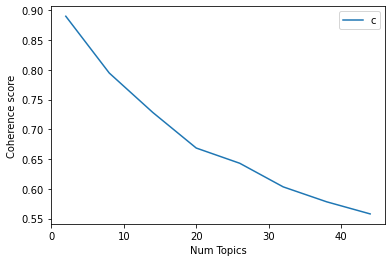

In [82]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def find_optimal_number_of_topics(dictionary, corpus, processed_data):
    limit = 50;
    start = 2;
    step = 6;
    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, 
                                                           texts = processed_data, 
                                                           start = start, 
                                                           limit = limit, step = step)
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel('Num Topics')
    plt.ylabel('Coherence score')
    plt.legend(('coherence_values'), loc = 'best')
    plt.show()
    

    
processed_data = [sent.strip().split(",") for sent in tqdm(open('/Users/hayeon/Downloads/2022-1(4-1)/빅데이터분석과응용/review_tokenized.csv', 'r', 
                                                               encoding='utf-8').readlines())]
dictionary = corpora.Dictionary(processed_data)
dictionary.filter_extremes(no_below=10, no_above=0.05)
corpus = [dictionary.doc2bow(text) for text in processed_data]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
logging.basicConfig(format = '%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

find_optimal_number_of_topics(dictionary, corpus, processed_data)

    - Number of unique tokens: 1842
    - Number of documents: 16598
    - 토픽의 수가 1일 때 응집도 가장 높으나, 임의로 토픽개수 5로 설정

In [83]:
from gensim import corpora
dictionary = corpora.Dictionary(tokenized_doc)
corpus = [dictionary.doc2bow(text) for text in tokenized_doc]

2022-05-22 19:06:37,042 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2022-05-22 19:06:37,183 : INFO : adding document #10000 to Dictionary(9819 unique tokens: ['environment', 'food', 'friendly', 'good', 'homely']...)
2022-05-22 19:06:37,271 : INFO : built Dictionary(12996 unique tokens: ['environment', 'food', 'friendly', 'good', 'homely']...) from 16597 documents (total 183154 corpus positions)


In [84]:
import gensim
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=6)
for topic in topics:
    print(topic)

2022-05-22 19:06:37,425 : INFO : using symmetric alpha at 0.2
2022-05-22 19:06:37,425 : INFO : using symmetric eta at 0.2
2022-05-22 19:06:37,427 : INFO : using serial LDA version on this node
2022-05-22 19:06:37,432 : INFO : running online (multi-pass) LDA training, 5 topics, 15 passes over the supplied corpus of 16597 documents, updating model once every 2000 documents, evaluating perplexity every 16597 documents, iterating 50x with a convergence threshold of 0.001000
2022-05-22 19:06:37,432 : INFO : PROGRESS: pass 0, at document #2000/16597
2022-05-22 19:06:38,069 : INFO : merging changes from 2000 documents into a model of 16597 documents
2022-05-22 19:06:38,073 : INFO : topic #0 (0.200): 0.059*"food" + 0.024*"good" + 0.020*"taste" + 0.018*"service" + 0.017*"price" + 0.016*"great" + 0.014*"environment" + 0.012*"place" + 0.010*"quality" + 0.010*"excellent"
2022-05-22 19:06:38,073 : INFO : topic #1 (0.200): 0.053*"food" + 0.030*"good" + 0.025*"chicken" + 0.020*"service" + 0.013*"best

2022-05-22 19:06:40,500 : INFO : topic diff=0.516939, rho=0.408248
2022-05-22 19:06:40,500 : INFO : PROGRESS: pass 0, at document #14000/16597
2022-05-22 19:06:40,896 : INFO : merging changes from 2000 documents into a model of 16597 documents
2022-05-22 19:06:40,898 : INFO : topic #0 (0.200): 0.064*"food" + 0.033*"service" + 0.029*"taste" + 0.025*"price" + 0.021*"good" + 0.020*"great" + 0.020*"worst" + 0.015*"quality" + 0.013*"ever" + 0.012*"excellent"
2022-05-22 19:06:40,899 : INFO : topic #1 (0.200): 0.025*"food" + 0.025*"chicken" + 0.018*"best" + 0.017*"good" + 0.011*"pizza" + 0.010*"like" + 0.009*"awesome" + 0.009*"rice" + 0.009*"service" + 0.008*"loved"
2022-05-22 19:06:40,899 : INFO : topic #2 (0.200): 0.089*"good" + 0.071*"food" + 0.040*"place" + 0.028*"service" + 0.027*"nice" + 0.027*"environment" + 0.012*"quality" + 0.012*"also" + 0.012*"well" + 0.011*"really"
2022-05-22 19:06:40,900 : INFO : topic #3 (0.200): 0.033*"pasta" + 0.029*"love" + 0.022*"best" + 0.021*"place" + 0.02

2022-05-22 19:06:43,047 : INFO : topic #1 (0.200): 0.029*"chicken" + 0.020*"food" + 0.016*"best" + 0.015*"good" + 0.011*"rice" + 0.011*"thai" + 0.011*"beef" + 0.009*"like" + 0.009*"burger" + 0.008*"ordered"
2022-05-22 19:06:43,048 : INFO : topic #2 (0.200): 0.092*"good" + 0.088*"food" + 0.047*"place" + 0.032*"service" + 0.030*"nice" + 0.028*"environment" + 0.016*"also" + 0.016*"awesome" + 0.014*"quality" + 0.014*"really"
2022-05-22 19:06:43,048 : INFO : topic #3 (0.200): 0.031*"best" + 0.029*"pasta" + 0.025*"love" + 0.019*"burger" + 0.018*"place" + 0.014*"food" + 0.014*"like" + 0.011*"good" + 0.011*"really" + 0.010*"town"
2022-05-22 19:06:43,049 : INFO : topic #4 (0.200): 0.030*"pizza" + 0.015*"food" + 0.013*"service" + 0.011*"time" + 0.010*"good" + 0.009*"best" + 0.008*"quality" + 0.008*"order" + 0.008*"restaurant" + 0.007*"taste"
2022-05-22 19:06:43,049 : INFO : topic diff=0.350377, rho=0.311611
2022-05-22 19:06:43,049 : INFO : PROGRESS: pass 1, at document #10000/16597
2022-05-22 19

2022-05-22 19:06:44,880 : INFO : topic #3 (0.200): 0.039*"best" + 0.028*"pasta" + 0.025*"love" + 0.023*"burger" + 0.016*"place" + 0.013*"like" + 0.010*"town" + 0.010*"food" + 0.009*"really" + 0.009*"awesome"
2022-05-22 19:06:44,880 : INFO : topic #4 (0.200): 0.044*"pizza" + 0.012*"service" + 0.010*"time" + 0.009*"food" + 0.008*"order" + 0.008*"branch" + 0.007*"went" + 0.006*"offer" + 0.006*"taste" + 0.005*"restaurant"
2022-05-22 19:06:44,881 : INFO : topic diff=0.323598, rho=0.297502
2022-05-22 19:06:44,881 : INFO : PROGRESS: pass 2, at document #4000/16597
2022-05-22 19:06:45,178 : INFO : merging changes from 2000 documents into a model of 16597 documents
2022-05-22 19:06:45,180 : INFO : topic #0 (0.200): 0.069*"food" + 0.033*"taste" + 0.030*"price" + 0.027*"service" + 0.025*"worst" + 0.024*"quality" + 0.015*"good" + 0.015*"ever" + 0.014*"quantity" + 0.013*"great"
2022-05-22 19:06:45,181 : INFO : topic #1 (0.200): 0.034*"chicken" + 0.015*"food" + 0.014*"good" + 0.013*"rice" + 0.012*"b

2022-05-22 19:06:46,687 : INFO : topic diff=0.300266, rho=0.297502
2022-05-22 19:06:46,687 : INFO : PROGRESS: pass 2, at document #16000/16597
2022-05-22 19:06:46,977 : INFO : merging changes from 2000 documents into a model of 16597 documents
2022-05-22 19:06:46,982 : INFO : topic #0 (0.200): 0.066*"food" + 0.032*"taste" + 0.028*"service" + 0.028*"price" + 0.026*"quality" + 0.025*"worst" + 0.017*"ever" + 0.014*"good" + 0.013*"poor" + 0.012*"money"
2022-05-22 19:06:46,984 : INFO : topic #1 (0.200): 0.034*"chicken" + 0.013*"good" + 0.013*"rice" + 0.012*"food" + 0.010*"beef" + 0.010*"ordered" + 0.010*"best" + 0.009*"like" + 0.008*"fish" + 0.008*"fried"
2022-05-22 19:06:46,985 : INFO : topic #2 (0.200): 0.096*"food" + 0.092*"good" + 0.047*"place" + 0.037*"service" + 0.029*"environment" + 0.028*"nice" + 0.020*"awesome" + 0.018*"really" + 0.018*"great" + 0.016*"quality"
2022-05-22 19:06:46,986 : INFO : topic #3 (0.200): 0.050*"best" + 0.034*"pasta" + 0.028*"love" + 0.017*"burger" + 0.016*"p

2022-05-22 19:06:48,812 : INFO : topic #1 (0.200): 0.032*"chicken" + 0.015*"good" + 0.012*"beef" + 0.012*"rice" + 0.011*"ordered" + 0.010*"food" + 0.009*"like" + 0.009*"thai" + 0.008*"taste" + 0.008*"best"
2022-05-22 19:06:48,814 : INFO : topic #2 (0.200): 0.099*"food" + 0.092*"good" + 0.048*"place" + 0.037*"service" + 0.029*"nice" + 0.028*"environment" + 0.022*"great" + 0.019*"awesome" + 0.017*"really" + 0.016*"loved"
2022-05-22 19:06:48,815 : INFO : topic #3 (0.200): 0.050*"best" + 0.033*"pasta" + 0.023*"love" + 0.020*"burger" + 0.016*"place" + 0.014*"coffee" + 0.013*"town" + 0.011*"like" + 0.008*"taste" + 0.008*"really"
2022-05-22 19:06:48,816 : INFO : topic #4 (0.200): 0.049*"pizza" + 0.012*"order" + 0.011*"time" + 0.011*"service" + 0.007*"waiter" + 0.007*"khabar" + 0.006*"went" + 0.006*"take" + 0.006*"offer" + 0.006*"chilo"
2022-05-22 19:06:48,817 : INFO : topic diff=0.281375, rho=0.285150
2022-05-22 19:06:48,817 : INFO : PROGRESS: pass 3, at document #12000/16597
2022-05-22 19:06

2022-05-22 19:06:50,579 : INFO : topic #3 (0.200): 0.055*"best" + 0.024*"love" + 0.024*"pasta" + 0.022*"coffee" + 0.022*"burger" + 0.017*"place" + 0.013*"town" + 0.010*"like" + 0.008*"awesome" + 0.008*"taste"
2022-05-22 19:06:50,580 : INFO : topic #4 (0.200): 0.038*"pizza" + 0.011*"order" + 0.010*"service" + 0.009*"time" + 0.008*"valo" + 0.007*"branch" + 0.007*"khabar" + 0.007*"went" + 0.006*"chilo" + 0.005*"even"
2022-05-22 19:06:50,580 : INFO : topic diff=0.261010, rho=0.274220
2022-05-22 19:06:50,580 : INFO : PROGRESS: pass 4, at document #6000/16597
2022-05-22 19:06:50,844 : INFO : merging changes from 2000 documents into a model of 16597 documents
2022-05-22 19:06:50,846 : INFO : topic #0 (0.200): 0.071*"food" + 0.028*"price" + 0.027*"taste" + 0.027*"service" + 0.027*"quality" + 0.024*"worst" + 0.016*"ever" + 0.014*"quantity" + 0.013*"money" + 0.012*"high"
2022-05-22 19:06:50,847 : INFO : topic #1 (0.200): 0.036*"chicken" + 0.015*"good" + 0.014*"beef" + 0.013*"rice" + 0.011*"order

2022-05-22 19:06:52,251 : INFO : topic diff=0.232812, rho=0.274220
2022-05-22 19:06:52,359 : INFO : -7.151 per-word bound, 142.1 perplexity estimate based on a held-out corpus of 597 documents with 6417 words
2022-05-22 19:06:52,360 : INFO : PROGRESS: pass 4, at document #16597/16597
2022-05-22 19:06:52,437 : INFO : merging changes from 597 documents into a model of 16597 documents
2022-05-22 19:06:52,439 : INFO : topic #0 (0.200): 0.070*"food" + 0.032*"worst" + 0.029*"quality" + 0.028*"price" + 0.027*"taste" + 0.026*"service" + 0.018*"ever" + 0.015*"quantity" + 0.013*"poor" + 0.013*"money"
2022-05-22 19:06:52,440 : INFO : topic #1 (0.200): 0.034*"chicken" + 0.015*"good" + 0.015*"rice" + 0.015*"beef" + 0.010*"ordered" + 0.010*"like" + 0.009*"taste" + 0.009*"burger" + 0.009*"items" + 0.008*"food"
2022-05-22 19:06:52,440 : INFO : topic #2 (0.200): 0.100*"food" + 0.093*"good" + 0.046*"place" + 0.036*"service" + 0.029*"environment" + 0.029*"nice" + 0.021*"awesome" + 0.019*"great" + 0.018*"

2022-05-22 19:06:54,398 : INFO : topic #1 (0.200): 0.033*"chicken" + 0.015*"good" + 0.012*"rice" + 0.012*"ordered" + 0.011*"beef" + 0.010*"like" + 0.009*"taste" + 0.008*"items" + 0.007*"thai" + 0.007*"menu"
2022-05-22 19:06:54,398 : INFO : topic #2 (0.200): 0.099*"food" + 0.089*"good" + 0.048*"place" + 0.038*"service" + 0.028*"environment" + 0.026*"nice" + 0.024*"great" + 0.021*"awesome" + 0.018*"really" + 0.016*"quality"
2022-05-22 19:06:54,399 : INFO : topic #3 (0.200): 0.064*"best" + 0.032*"pasta" + 0.023*"burger" + 0.023*"love" + 0.017*"place" + 0.015*"town" + 0.013*"coffee" + 0.010*"like" + 0.008*"taste" + 0.008*"dhaka"
2022-05-22 19:06:54,400 : INFO : topic #4 (0.200): 0.057*"pizza" + 0.010*"order" + 0.010*"service" + 0.010*"time" + 0.007*"valo" + 0.007*"pizzas" + 0.007*"sbarro" + 0.007*"offer" + 0.007*"went" + 0.006*"waiter"
2022-05-22 19:06:54,400 : INFO : topic diff=0.228213, rho=0.264457
2022-05-22 19:06:54,401 : INFO : PROGRESS: pass 5, at document #14000/16597
2022-05-22 19

2022-05-22 19:06:56,053 : INFO : topic #3 (0.200): 0.066*"best" + 0.026*"pasta" + 0.024*"love" + 0.020*"burger" + 0.020*"coffee" + 0.018*"place" + 0.015*"town" + 0.010*"dhaka" + 0.009*"like" + 0.008*"restaurant"
2022-05-22 19:06:56,053 : INFO : topic #4 (0.200): 0.041*"pizza" + 0.011*"order" + 0.010*"service" + 0.008*"time" + 0.008*"valo" + 0.007*"khabar" + 0.007*"chilo" + 0.006*"went" + 0.006*"waiter" + 0.006*"branch"
2022-05-22 19:06:56,053 : INFO : topic diff=0.210746, rho=0.255668
2022-05-22 19:06:56,054 : INFO : PROGRESS: pass 6, at document #8000/16597
2022-05-22 19:06:56,319 : INFO : merging changes from 2000 documents into a model of 16597 documents
2022-05-22 19:06:56,322 : INFO : topic #0 (0.200): 0.069*"food" + 0.029*"service" + 0.027*"price" + 0.027*"quality" + 0.026*"worst" + 0.025*"taste" + 0.017*"ever" + 0.015*"quantity" + 0.013*"money" + 0.013*"poor"
2022-05-22 19:06:56,323 : INFO : topic #1 (0.200): 0.031*"chicken" + 0.015*"good" + 0.013*"beef" + 0.012*"rice" + 0.011*"

2022-05-22 19:06:57,503 : INFO : topic diff=0.159352, rho=0.255668
2022-05-22 19:06:57,503 : INFO : PROGRESS: pass 7, at document #2000/16597
2022-05-22 19:06:57,764 : INFO : merging changes from 2000 documents into a model of 16597 documents
2022-05-22 19:06:57,766 : INFO : topic #0 (0.200): 0.072*"food" + 0.030*"worst" + 0.030*"quality" + 0.028*"price" + 0.027*"service" + 0.026*"taste" + 0.018*"ever" + 0.017*"quantity" + 0.013*"money" + 0.012*"poor"
2022-05-22 19:06:57,766 : INFO : topic #1 (0.200): 0.036*"chicken" + 0.016*"good" + 0.014*"rice" + 0.013*"beef" + 0.011*"ordered" + 0.010*"like" + 0.010*"taste" + 0.009*"platter" + 0.008*"burger" + 0.008*"menu"
2022-05-22 19:06:57,767 : INFO : topic #2 (0.200): 0.104*"food" + 0.091*"good" + 0.046*"place" + 0.038*"service" + 0.028*"environment" + 0.027*"nice" + 0.022*"great" + 0.021*"awesome" + 0.018*"really" + 0.016*"also"
2022-05-22 19:06:57,767 : INFO : topic #3 (0.200): 0.068*"best" + 0.033*"pasta" + 0.027*"burger" + 0.023*"love" + 0.0

2022-05-22 19:06:59,267 : INFO : topic #1 (0.200): 0.032*"chicken" + 0.016*"good" + 0.012*"ordered" + 0.011*"rice" + 0.011*"beef" + 0.011*"like" + 0.010*"taste" + 0.009*"items" + 0.008*"cheese" + 0.008*"thai"
2022-05-22 19:06:59,267 : INFO : topic #2 (0.200): 0.097*"food" + 0.091*"good" + 0.047*"place" + 0.038*"service" + 0.029*"environment" + 0.027*"nice" + 0.024*"great" + 0.021*"awesome" + 0.019*"really" + 0.016*"also"
2022-05-22 19:06:59,268 : INFO : topic #3 (0.200): 0.074*"best" + 0.043*"pasta" + 0.026*"love" + 0.020*"coffee" + 0.020*"burger" + 0.018*"place" + 0.017*"town" + 0.010*"dhaka" + 0.009*"like" + 0.008*"restaurant"
2022-05-22 19:06:59,268 : INFO : topic #4 (0.200): 0.080*"pizza" + 0.010*"service" + 0.010*"order" + 0.009*"offer" + 0.009*"pizzas" + 0.008*"time" + 0.007*"valo" + 0.007*"chilo" + 0.006*"went" + 0.006*"branch"
2022-05-22 19:06:59,269 : INFO : topic diff=0.196338, rho=0.247700
2022-05-22 19:06:59,269 : INFO : PROGRESS: pass 7, at document #16000/16597
2022-05-22

2022-05-22 19:07:00,720 : INFO : topic #3 (0.200): 0.075*"best" + 0.036*"pasta" + 0.026*"burger" + 0.023*"love" + 0.018*"place" + 0.016*"coffee" + 0.015*"town" + 0.012*"dhaka" + 0.009*"restaurant" + 0.008*"like"
2022-05-22 19:07:00,720 : INFO : topic #4 (0.200): 0.040*"pizza" + 0.012*"order" + 0.010*"service" + 0.009*"valo" + 0.008*"time" + 0.008*"khabar" + 0.007*"chilo" + 0.007*"take" + 0.007*"waiter" + 0.006*"offer"
2022-05-22 19:07:00,720 : INFO : topic diff=0.175775, rho=0.240434
2022-05-22 19:07:00,721 : INFO : PROGRESS: pass 8, at document #10000/16597
2022-05-22 19:07:00,972 : INFO : merging changes from 2000 documents into a model of 16597 documents
2022-05-22 19:07:00,974 : INFO : topic #0 (0.200): 0.069*"food" + 0.030*"service" + 0.026*"quality" + 0.026*"price" + 0.026*"worst" + 0.024*"taste" + 0.017*"ever" + 0.014*"quantity" + 0.014*"poor" + 0.013*"money"
2022-05-22 19:07:00,975 : INFO : topic #1 (0.200): 0.030*"chicken" + 0.016*"good" + 0.012*"beef" + 0.012*"ordered" + 0.01

2022-05-22 19:07:02,129 : INFO : topic diff=0.183541, rho=0.233772
2022-05-22 19:07:02,130 : INFO : PROGRESS: pass 9, at document #4000/16597
2022-05-22 19:07:02,367 : INFO : merging changes from 2000 documents into a model of 16597 documents
2022-05-22 19:07:02,369 : INFO : topic #0 (0.200): 0.070*"food" + 0.029*"quality" + 0.028*"worst" + 0.028*"price" + 0.027*"service" + 0.024*"taste" + 0.017*"ever" + 0.016*"quantity" + 0.013*"money" + 0.012*"poor"
2022-05-22 19:07:02,370 : INFO : topic #1 (0.200): 0.033*"chicken" + 0.015*"good" + 0.013*"rice" + 0.012*"beef" + 0.011*"steak" + 0.011*"ordered" + 0.010*"like" + 0.010*"taste" + 0.008*"platter" + 0.008*"menu"
2022-05-22 19:07:02,370 : INFO : topic #2 (0.200): 0.102*"food" + 0.089*"good" + 0.050*"place" + 0.037*"service" + 0.028*"environment" + 0.028*"nice" + 0.022*"great" + 0.021*"awesome" + 0.018*"really" + 0.016*"also"
2022-05-22 19:07:02,371 : INFO : topic #3 (0.200): 0.079*"best" + 0.027*"pasta" + 0.024*"love" + 0.022*"coffee" + 0.02

2022-05-22 19:07:03,818 : INFO : topic #1 (0.200): 0.032*"chicken" + 0.015*"good" + 0.012*"ordered" + 0.012*"rice" + 0.011*"like" + 0.011*"beef" + 0.010*"taste" + 0.009*"items" + 0.008*"fried" + 0.007*"menu"
2022-05-22 19:07:03,819 : INFO : topic #2 (0.200): 0.101*"food" + 0.092*"good" + 0.047*"place" + 0.038*"service" + 0.028*"environment" + 0.027*"nice" + 0.023*"great" + 0.022*"awesome" + 0.019*"really" + 0.016*"also"
2022-05-22 19:07:03,820 : INFO : topic #3 (0.200): 0.086*"best" + 0.038*"pasta" + 0.026*"love" + 0.020*"burger" + 0.018*"place" + 0.017*"coffee" + 0.016*"town" + 0.012*"dhaka" + 0.009*"restaurant" + 0.009*"like"
2022-05-22 19:07:03,820 : INFO : topic #4 (0.200): 0.070*"pizza" + 0.011*"order" + 0.010*"service" + 0.008*"valo" + 0.008*"offer" + 0.008*"time" + 0.007*"pizzas" + 0.007*"chilo" + 0.007*"khabar" + 0.006*"delivery"
2022-05-22 19:07:03,821 : INFO : topic diff=0.163743, rho=0.233772
2022-05-22 19:07:03,921 : INFO : -7.075 per-word bound, 134.8 perplexity estimate b

2022-05-22 19:07:05,211 : INFO : topic #3 (0.200): 0.082*"best" + 0.035*"pasta" + 0.023*"love" + 0.022*"burger" + 0.018*"place" + 0.017*"coffee" + 0.015*"town" + 0.014*"dhaka" + 0.009*"restaurant" + 0.008*"like"
2022-05-22 19:07:05,211 : INFO : topic #4 (0.200): 0.053*"pizza" + 0.013*"order" + 0.009*"service" + 0.008*"time" + 0.008*"valo" + 0.007*"khabar" + 0.007*"waiter" + 0.007*"offer" + 0.007*"chilo" + 0.006*"delivery"
2022-05-22 19:07:05,212 : INFO : topic diff=0.169349, rho=0.227635
2022-05-22 19:07:05,212 : INFO : PROGRESS: pass 10, at document #12000/16597
2022-05-22 19:07:05,457 : INFO : merging changes from 2000 documents into a model of 16597 documents
2022-05-22 19:07:05,459 : INFO : topic #0 (0.200): 0.067*"food" + 0.030*"service" + 0.028*"quality" + 0.025*"worst" + 0.025*"price" + 0.024*"taste" + 0.017*"ever" + 0.014*"quantity" + 0.013*"money" + 0.013*"poor"
2022-05-22 19:07:05,460 : INFO : topic #1 (0.200): 0.031*"chicken" + 0.015*"good" + 0.012*"ordered" + 0.012*"rice" +

2022-05-22 19:07:06,801 : INFO : topic #4 (0.200): 0.046*"pizza" + 0.011*"order" + 0.009*"service" + 0.009*"valo" + 0.008*"branch" + 0.007*"khabar" + 0.007*"time" + 0.007*"chilo" + 0.006*"offer" + 0.005*"delivery"
2022-05-22 19:07:06,802 : INFO : topic diff=0.166298, rho=0.221957
2022-05-22 19:07:06,802 : INFO : PROGRESS: pass 11, at document #6000/16597
2022-05-22 19:07:07,035 : INFO : merging changes from 2000 documents into a model of 16597 documents
2022-05-22 19:07:07,037 : INFO : topic #0 (0.200): 0.073*"food" + 0.029*"service" + 0.028*"quality" + 0.026*"price" + 0.025*"worst" + 0.024*"taste" + 0.015*"ever" + 0.015*"quantity" + 0.013*"money" + 0.012*"poor"
2022-05-22 19:07:07,038 : INFO : topic #1 (0.200): 0.033*"chicken" + 0.016*"good" + 0.013*"beef" + 0.012*"rice" + 0.011*"ordered" + 0.010*"like" + 0.010*"taste" + 0.009*"steak" + 0.008*"platter" + 0.008*"menu"
2022-05-22 19:07:07,038 : INFO : topic #2 (0.200): 0.105*"food" + 0.090*"good" + 0.049*"place" + 0.037*"service" + 0.02

2022-05-22 19:07:08,344 : INFO : PROGRESS: pass 11, at document #16597/16597
2022-05-22 19:07:08,411 : INFO : merging changes from 597 documents into a model of 16597 documents
2022-05-22 19:07:08,414 : INFO : topic #0 (0.200): 0.070*"food" + 0.031*"worst" + 0.029*"quality" + 0.028*"service" + 0.026*"price" + 0.024*"taste" + 0.017*"ever" + 0.015*"quantity" + 0.013*"poor" + 0.012*"money"
2022-05-22 19:07:08,414 : INFO : topic #1 (0.200): 0.032*"chicken" + 0.016*"good" + 0.014*"rice" + 0.013*"beef" + 0.011*"ordered" + 0.011*"like" + 0.010*"taste" + 0.009*"burger" + 0.009*"items" + 0.008*"cheese"
2022-05-22 19:07:08,414 : INFO : topic #2 (0.200): 0.103*"food" + 0.093*"good" + 0.047*"place" + 0.037*"service" + 0.029*"environment" + 0.028*"nice" + 0.022*"awesome" + 0.022*"great" + 0.019*"really" + 0.016*"also"
2022-05-22 19:07:08,415 : INFO : topic #3 (0.200): 0.083*"best" + 0.040*"pasta" + 0.024*"burger" + 0.023*"love" + 0.018*"place" + 0.014*"town" + 0.013*"coffee" + 0.012*"dhaka" + 0.010

2022-05-22 19:07:09,926 : INFO : topic #1 (0.200): 0.031*"chicken" + 0.015*"good" + 0.012*"ordered" + 0.012*"rice" + 0.011*"like" + 0.011*"beef" + 0.010*"taste" + 0.008*"items" + 0.007*"really" + 0.007*"thai"
2022-05-22 19:07:09,927 : INFO : topic #2 (0.200): 0.101*"food" + 0.090*"good" + 0.048*"place" + 0.038*"service" + 0.028*"environment" + 0.026*"nice" + 0.026*"great" + 0.021*"awesome" + 0.019*"really" + 0.016*"also"
2022-05-22 19:07:09,928 : INFO : topic #3 (0.200): 0.089*"best" + 0.033*"pasta" + 0.023*"love" + 0.023*"burger" + 0.018*"place" + 0.016*"town" + 0.015*"coffee" + 0.014*"dhaka" + 0.010*"restaurant" + 0.008*"like"
2022-05-22 19:07:09,929 : INFO : topic #4 (0.200): 0.059*"pizza" + 0.011*"order" + 0.009*"service" + 0.008*"valo" + 0.007*"offer" + 0.007*"pizzas" + 0.007*"time" + 0.007*"waiter" + 0.007*"branch" + 0.007*"sbarro"
2022-05-22 19:07:09,929 : INFO : topic diff=0.154321, rho=0.216683
2022-05-22 19:07:09,930 : INFO : PROGRESS: pass 12, at document #14000/16597
2022-0

2022-05-22 19:07:11,311 : INFO : topic #2 (0.200): 0.105*"food" + 0.090*"good" + 0.049*"place" + 0.037*"service" + 0.029*"environment" + 0.028*"nice" + 0.025*"great" + 0.022*"awesome" + 0.018*"really" + 0.016*"also"
2022-05-22 19:07:11,312 : INFO : topic #3 (0.200): 0.087*"best" + 0.028*"pasta" + 0.024*"love" + 0.021*"burger" + 0.020*"coffee" + 0.019*"place" + 0.016*"dhaka" + 0.015*"town" + 0.010*"restaurant" + 0.008*"luck"
2022-05-22 19:07:11,312 : INFO : topic #4 (0.200): 0.046*"pizza" + 0.012*"order" + 0.009*"valo" + 0.009*"service" + 0.007*"khabar" + 0.007*"chilo" + 0.006*"time" + 0.006*"branch" + 0.006*"waiter" + 0.006*"offer"
2022-05-22 19:07:11,312 : INFO : topic diff=0.144422, rho=0.211769
2022-05-22 19:07:11,313 : INFO : PROGRESS: pass 13, at document #8000/16597
2022-05-22 19:07:11,569 : INFO : merging changes from 2000 documents into a model of 16597 documents
2022-05-22 19:07:11,571 : INFO : topic #0 (0.200): 0.071*"food" + 0.030*"service" + 0.027*"quality" + 0.026*"price" 

2022-05-22 19:07:12,685 : INFO : topic #3 (0.200): 0.085*"best" + 0.040*"pasta" + 0.025*"burger" + 0.023*"love" + 0.018*"place" + 0.014*"town" + 0.013*"coffee" + 0.013*"dhaka" + 0.010*"restaurant" + 0.009*"luck"
2022-05-22 19:07:12,685 : INFO : topic #4 (0.200): 0.061*"pizza" + 0.011*"order" + 0.009*"service" + 0.009*"valo" + 0.007*"chilo" + 0.007*"khabar" + 0.007*"offer" + 0.007*"pizzas" + 0.006*"time" + 0.006*"branch"
2022-05-22 19:07:12,685 : INFO : topic diff=0.112332, rho=0.211769
2022-05-22 19:07:12,686 : INFO : PROGRESS: pass 14, at document #2000/16597
2022-05-22 19:07:12,934 : INFO : merging changes from 2000 documents into a model of 16597 documents
2022-05-22 19:07:12,936 : INFO : topic #0 (0.200): 0.072*"food" + 0.029*"quality" + 0.029*"worst" + 0.028*"service" + 0.026*"price" + 0.024*"taste" + 0.016*"ever" + 0.016*"quantity" + 0.012*"money" + 0.012*"poor"
2022-05-22 19:07:12,937 : INFO : topic #1 (0.200): 0.035*"chicken" + 0.015*"good" + 0.013*"rice" + 0.013*"beef" + 0.011

2022-05-22 19:07:14,107 : INFO : topic diff=0.142961, rho=0.207174
2022-05-22 19:07:14,108 : INFO : PROGRESS: pass 14, at document #14000/16597
2022-05-22 19:07:14,335 : INFO : merging changes from 2000 documents into a model of 16597 documents
2022-05-22 19:07:14,337 : INFO : topic #0 (0.200): 0.066*"food" + 0.031*"service" + 0.027*"quality" + 0.027*"worst" + 0.025*"price" + 0.023*"taste" + 0.017*"ever" + 0.014*"poor" + 0.013*"quantity" + 0.013*"money"
2022-05-22 19:07:14,338 : INFO : topic #1 (0.200): 0.031*"chicken" + 0.015*"good" + 0.012*"ordered" + 0.011*"like" + 0.011*"rice" + 0.011*"beef" + 0.010*"taste" + 0.008*"items" + 0.008*"cheese" + 0.008*"really"
2022-05-22 19:07:14,338 : INFO : topic #2 (0.200): 0.099*"food" + 0.091*"good" + 0.047*"place" + 0.038*"service" + 0.029*"environment" + 0.027*"nice" + 0.025*"great" + 0.022*"awesome" + 0.019*"really" + 0.016*"also"
2022-05-22 19:07:14,339 : INFO : topic #3 (0.200): 0.089*"best" + 0.042*"pasta" + 0.026*"love" + 0.021*"burger" + 0

(0, '0.071*"food" + 0.030*"worst" + 0.029*"quality" + 0.028*"service" + 0.025*"price" + 0.024*"taste"')
(1, '0.032*"chicken" + 0.016*"good" + 0.013*"rice" + 0.013*"beef" + 0.011*"ordered" + 0.011*"like"')
(2, '0.103*"food" + 0.093*"good" + 0.047*"place" + 0.037*"service" + 0.029*"environment" + 0.028*"nice"')
(3, '0.085*"best" + 0.040*"pasta" + 0.025*"burger" + 0.023*"love" + 0.018*"place" + 0.014*"town"')
(4, '0.061*"pizza" + 0.011*"order" + 0.009*"service" + 0.009*"valo" + 0.007*"chilo" + 0.007*"khabar"')


In [85]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

In [86]:
def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame()
    
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)
        
        for j, (topic_num, prop_topic) in enumerate(doc):
            if j ==0:
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_list]), 
                                                ignore_index=True)
            else:
                break
    return(topic_table)

In [87]:
topictable = make_topictable_per_doc(ldamodel, corpus)
topictable = topictable.reset_index()
topictable.columns = ['문서번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중', '각 토픽의 비중']
topictable[:10]

,문서번호,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 비중
0,0,2.0,0.8855,"[(0, 0.02868236), (1, 0.028618868), (2, 0.8854..."
1,1,2.0,0.9422,"[(0, 0.014515747), (1, 0.014449372), (2, 0.942..."
2,2,2.0,0.6658,"[(0, 0.26981726), (2, 0.6657856), (4, 0.048334..."
3,3,4.0,0.5150,"[(0, 0.22099277), (2, 0.15896931), (3, 0.09738..."
4,4,2.0,0.8461,"[(0, 0.05728723), (2, 0.84610987), (3, 0.04848..."
5,5,2.0,0.4007,"[(0, 0.02751699), (1, 0.22193739), (2, 0.40073..."
6,6,1.0,0.4065,"[(1, 0.40654206), (2, 0.27275795), (3, 0.18176..."
7,7,2.0,0.8316,"[(0, 0.11767683), (1, 0.017055567), (2, 0.8315..."
8,8,3.0,0.4516,"[(0, 0.02525733), (1, 0.02525587), (2, 0.28420..."
9,9,2.0,0.8392,"[(0, 0.04021351), (1, 0.04009451), (2, 0.83916..."


### 각 그룹에 적절한 토픽명 붙이기

In [88]:
topic = pd.DataFrame(topics)
topic[1] = topic[1].str.replace("[+]", ",")
topic[1] = topic[1].str.replace("[^a-zA-Z, ]", "")
topic.columns = ['topic', 'sentence']
topic

,topic,sentence
0,0,"food , worst , quality , service , price , taste"
1,1,"chicken , good , rice , beef , ordered , like"
2,2,"food , good , place , service , environment , ..."
3,3,"best , pasta , burger , love , place , town"
4,4,"pizza , order , service , valo , chilo , khabar"


In [89]:
topic['topic'][0] = '식당 총평'
topic['topic'][1] = '고기 추천'
topic['topic'][2] = '식당 환경'
topic['topic'][3] = '양식 추천'
topic['topic'][4] = '식당 서비스'

In [90]:
topic

,topic,sentence
0,식당 총평,"food , worst , quality , service , price , taste"
1,고기 추천,"chicken , good , rice , beef , ordered , like"
2,식당 환경,"food , good , place , service , environment , ..."
3,양식 추천,"best , pasta , burger , love , place , town"
4,식당 서비스,"pizza , order , service , valo , chilo , khabar"
